In [1]:
import os
import numpy as np
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from localization import datasets
from localization import models
from localization import samplers
from localization.experiments.batched_online import simulate, make_key

from utils import ipr, entropy, entropy_sort, mean_sort, var_sort, plot_receptive_fields, plot_rf_evolution

def simulate_or_load(**kwargs):
    path_key = make_key(**kwargs)
    if path_key + '.npz' in os.listdir('../localization/results/weights'):
        print('Already simulated')
        data = np.load('../localization/results/weights/' + path_key + '.npz', allow_pickle=True)
        weights_, metrics_ = data['weights'], data['metrics']
    else:
        print('Simulating')
        weights_, metrics_ = simulate(**kwargs)
    return weights_, metrics_

def build_gaussian_covariance(L, xi):
    C = np.abs(jnp.tile(jnp.arange(L)[:, jnp.newaxis], (1, L)) - jnp.tile(jnp.arange(L), (L, 1)))
    C = jnp.minimum(C, L - C)
    C = np.exp(-C ** 2 / (xi ** 2))
    return C

config_ = dict(
    # data config
    num_dimensions=40, xi1=2, xi2=1,
    # num_dimensions=100, xi1=6, xi2=3,
    dataset_cls=datasets.NonlinearGPDataset,
    batch_size=1000,
    support=(-1, 1), # defunct
    class_proportion=0.5,
    # model config
    model_cls=models.SimpleNet,
    num_hiddens=40,
    # num_hiddens=100,
    activation='relu',
    use_bias=False,
    sampler_cls=samplers.EpochSampler,
    init_fn=models.xavier_normal_init,
    init_scale=1.,
    # learning config
    num_epochs=5000,
    # num_epochs=20000,
    evaluation_interval=100,
    optimizer_fn=optax.sgd,
    learning_rate=5.,
    # experiment config
    seed=0,
    save_=True,
    wandb_=False,
)

### Load the high-gain model

Already simulated


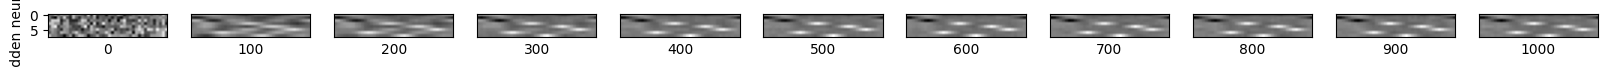

In [52]:
# high gain
config = config_.copy()
config.update(dict(
    num_hiddens=8, learning_rate=1., num_epochs=5000, gain=3,
    batch_size=1000, evaluation_interval=500,
))

weights, metrics = simulate_or_load(**config)
fig, axs = plot_receptive_fields(weights, num_cols=11, evaluation_interval=100, figsize=(20, 10), reordering_fn=entropy_sort, ind=-1)

### Test it on the low-gain dataset

In [47]:
config = config_.copy()
config.update(dict(gain=0.01))
dataset = datasets.NonlinearGPDataset(key=jax.random.PRNGKey(0), **config, num_exemplars=10000)
x, y = dataset[:10000]

$K = 8$ (underparameterized)

In [53]:
# not that much worse than the low-gain model, which achieved an accuracy of 70% and a loss of 0.198
weight_ = weights[-1]
print( np.mean( (jax.nn.relu(weight_ @ x.T).mean(axis=0) > 0.5) == y ) )
print( np.mean( (jax.nn.relu(weight_ @ x.T).mean(axis=0) - y) ** 2 ) )

0.6921
0.20083955


$K = 40$ (equiparameterized)

In [41]:
# not that much worse than the low-gain model, which achieved an accuracy of 73% and a loss of 0.193
weight_ = weights[-1]
print( np.mean( (jax.nn.relu(weight_ @ x.T).mean(axis=0) > 0.5) == y ) )
print( np.mean( (jax.nn.relu(weight_ @ x.T).mean(axis=0) - y) ** 2 ) )

0.6623
0.20631444


$K = 100$ (overparameterized)

In [42]:
# noticeably worse than the low-gain model, which achieved an accuracy of 73% and a loss of 0.196
weight_ = weights[-1]
print( np.mean( (jax.nn.relu(weight_ @ x.T).mean(axis=0) > 0.5) == y ) )
print( np.mean( (jax.nn.relu(weight_ @ x.T).mean(axis=0) - y) ** 2 ) )

0.6623
0.20631444


This has two important implications:

1. We might be able to always use a localized model as the teacher in a student-teacher analysis.
2. It begs the question: if localized receptive fields do just as well with the Gaussian data, why doesn't the model find this structure? What about higher-order statistics necessitates this?

(Before asserting this final sentence, we must check that a low-gain/non-localized model does not solve the high-gain task.)

## Checking the converse

Does a low-gain model solve the high-gain task?

### Load the low-gain model

Already simulated


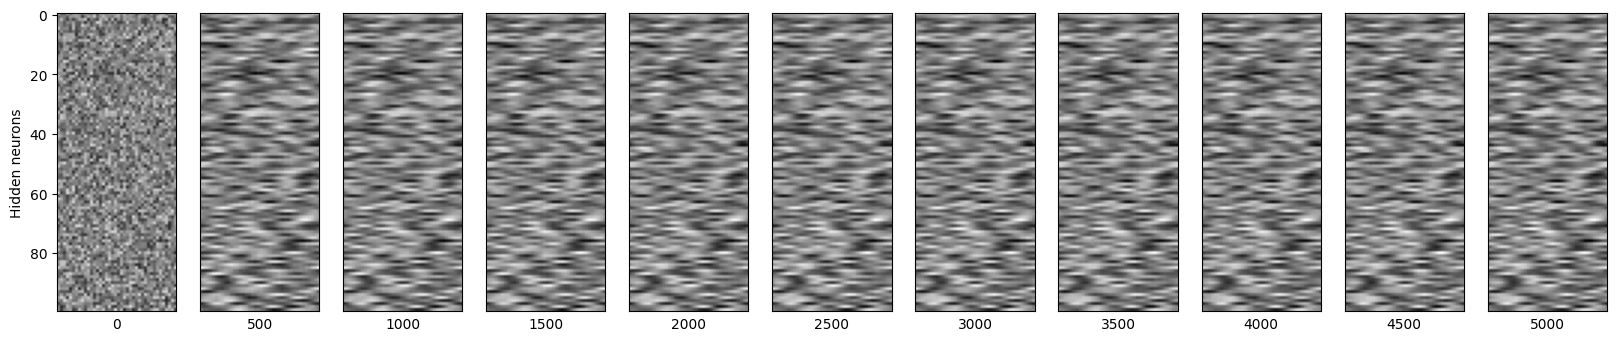

In [87]:
# low gain
config = config_.copy()
config.update(dict(
    num_hiddens=100, learning_rate=10., num_epochs=5000, gain=0.01,
    batch_size=1000, evaluation_interval=500,
))

weights, metrics = simulate_or_load(**config)
fig, axs = plot_receptive_fields(weights, num_cols=11, evaluation_interval=500, figsize=(20, 10), reordering_fn=entropy_sort, ind=-1)

### Test it on the high-gain dataset

In [94]:
config = config_.copy()
config.update(dict(gain=3))
dataset = datasets.NonlinearGPDataset(key=jax.random.PRNGKey(0), **config, num_exemplars=10000)
x, y = dataset[:10000]

$K = 8$ (underparameterized)

In [60]:
# not that much worse than the high-gain model, which achieved an accuracy of 74% and a loss of 0.192
weight_ = weights[-1]
print( np.mean( (jax.nn.relu(weight_ @ x.T).mean(axis=0) > 0.5) == y ) )
print( np.mean( (jax.nn.relu(weight_ @ x.T).mean(axis=0) - y) ** 2 ) )

0.7362
0.19152366


$K = 40$ (equiparameterized)

In [78]:
# no different than the high-gain model, which achieved an accuracy of 78% and a loss of 0.184
weight_ = weights[-1]
print( np.mean( (jax.nn.relu(weight_ @ x.T).mean(axis=0) > 0.5) == y ) )
print( np.mean( (jax.nn.relu(weight_ @ x.T).mean(axis=0) - y) ** 2 ) )

0.7809
0.1904248


$K = 100$ (overparameterized)

In [95]:
# no different than the high-gain model, which achieved an accuracy of 80% and a loss of 0.182
weight_ = weights[-1]
print( np.mean( (jax.nn.relu(weight_ @ x.T).mean(axis=0) > 0.5) == y ) )
print( np.mean( (jax.nn.relu(weight_ @ x.T).mean(axis=0) - y) ** 2 ) )

0.7849
0.19006349


Wow! So either receptive field could solve the other's task! This is counterintuitive.

We need to confirm this is consistent with sigmoid activation.

## Sigmoid activation

### Load high-gain model

Already simulated


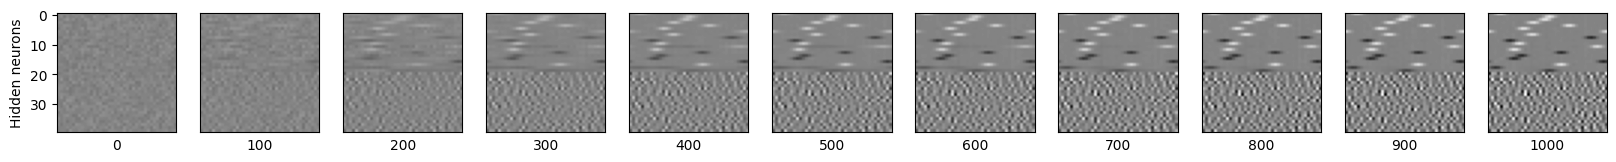

In [127]:
# high gain
config = config_.copy()
config.update(dict(
    num_hiddens=40, learning_rate=50., num_epochs=1000, gain=3,
    batch_size=1000, evaluation_interval=100, activation='sigmoid', use_bias=True,
))

weights, metrics = simulate_or_load(**config)
fig, axs = plot_receptive_fields(weights, num_cols=11, evaluation_interval=100, figsize=(20, 10), reordering_fn=entropy_sort, ind=-1)

In [129]:
config = config_.copy()
config.update(dict(gain=0.01))
dataset = datasets.NonlinearGPDataset(key=jax.random.PRNGKey(0), **config, num_exemplars=10000)
x, y = dataset[:10000]

$K = 40$ (equiparamaterized)

In [131]:
# somehow better than the low-gain model, which achieved an accuracy of 80% and a loss of 0.196
weights_ = weights[-1]
bias_ = metrics[-1][3].reshape(-1, 1) # lol forgot I saved it like this
print( np.mean( (jax.nn.sigmoid(weight_ @ x.T + bias_).mean(axis=0) > 0.5) == y ) )
print( np.mean( (jax.nn.sigmoid(weight_ @ x.T + bias_).mean(axis=0) - y) ** 2 ) )

0.91389996
0.19591738


### Load low-gain model

Already simulated


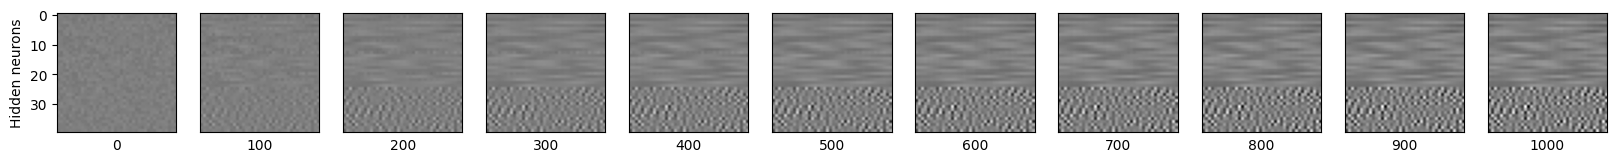

In [141]:
# low gain
config = config_.copy()
config.update(dict(
    num_hiddens=40, learning_rate=50., num_epochs=1000, gain=0.01,
    batch_size=1000, evaluation_interval=100, activation='sigmoid', use_bias=True,
))

weights, metrics = simulate_or_load(**config)
fig, axs = plot_receptive_fields(weights, num_cols=11, evaluation_interval=100, figsize=(20, 10), reordering_fn=entropy_sort, ind=-1)

In [142]:
config = config_.copy()
config.update(dict(gain=3))
dataset = datasets.NonlinearGPDataset(key=jax.random.PRNGKey(0), **config, num_exemplars=10000)
x, y = dataset[:10000]

In [143]:
# somewhat worse than the high-gain model, which achieved an accuracy of 89% and a loss of 0.20
weights_ = weights[-1]
bias_ = metrics[-1][3].reshape(-1, 1) # lol forgot I saved it like this
print( np.mean( (jax.nn.sigmoid(weight_ @ x.T + bias_).mean(axis=0) > 0.5) == y ) )
print( np.mean( (jax.nn.sigmoid(weight_ @ x.T + bias_).mean(axis=0) - y) ** 2 ) )

0.7592
0.22200303


## Can we get zero loss?

If so, we could can use the localized model as the teacher.

Already simulated


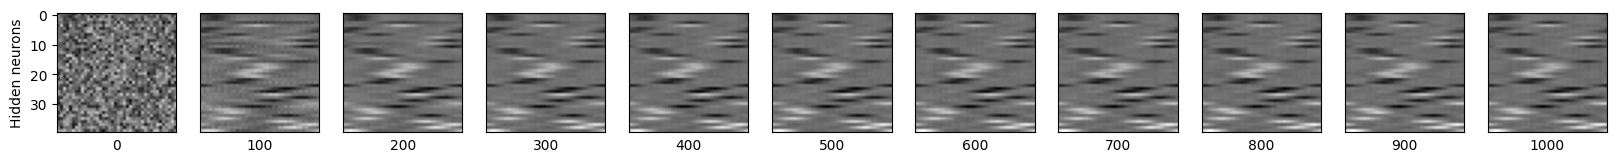

In [149]:
# high gain
config = config_.copy()
config.update(dict(
    xi1=6, xi2=1,
    num_hiddens=40, learning_rate=10., num_epochs=1000, gain=3,
    batch_size=1000, evaluation_interval=100,
))

weights, metrics = simulate_or_load(**config)
fig, axs = plot_receptive_fields(weights, num_cols=11, evaluation_interval=100, figsize=(20, 10), reordering_fn=entropy_sort, ind=-1)